In [1]:
import numpy as np
from scipy.stats import special_ortho_group

N = 10000 # number of samples to generate; the actual size may be smaller because of the prior
D = 32 # number of dims, which should be an even int
Q = 0.01
lower = np.full(D, -15.) # lower bound of the prior
upper = np.full(D, 15.) # upper bound of the prior
bound = np.array((lower, upper)).T
diff = bound[:, 1] - bound[:, 0]
const = np.sum(np.log(diff)) # normalization of the flat prior

def logp(x):
    x = x @ A.T
    return -np.sum((x[..., ::2]**2 - x[..., 1::2])**2 / Q + 
                   (x[..., ::2] - 1)**2, axis=-1) - const

def grad(x):
    x = x @ A.T
    _pfpx2i1 = 2 * (x[..., 1::2] - x[..., ::2]**2) / Q
    _pfpx2i = 2 * (x[..., ::2] - 1) - 2 * x[..., ::2] * _pfpx2i1
    res = np.empty_like(x)
    res[..., ::2] = _pfpx2i
    res[..., 1::2] = _pfpx2i1
    return -res @ A

def _in_bound(x, bound):
    xt = np.atleast_2d(x).T
    return np.product([np.where(xi>bound[i,0], True, False) * 
                       np.where(xi<bound[i,1], True, False) for i, xi in 
                       enumerate(xt)], axis=0).astype(bool)

In [2]:
np.random.seed(0)
A = special_ortho_group.rvs(D)
_x = np.random.randn(N, D) * 0.5**0.5 + 1
_x[:, 1::2] = _x[:, ::2]**2 + np.random.randn(N, D // 2) * (0.5 * Q)**0.5
x = _x @ A # rotate the samples with the random matrix A
x = x[_in_bound(x, bound)]
np.save('banana_{}.npy'.format(x.shape[0]), x)

Removed no burn in


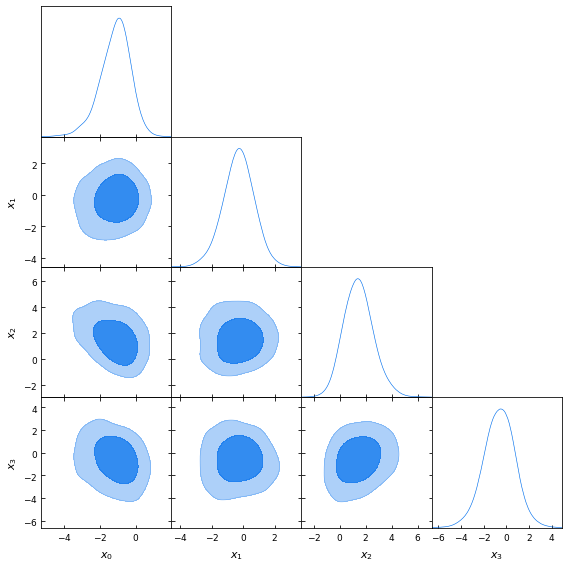

In [4]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt

names = ["x_%s"%i for i in range(4)]
labels = ["x_%s"%i for i in range(4)]
s = MCSamples(samples=x[:, :4], names=names, labels=labels)
g = plots.getSubplotPlotter()
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.triangle_plot([s], filled=True, contour_args={'alpha':0.8})
plt.show()